# Objetivo do notebook

[Deploy](https://huggingface.co/spaces/HellSank/coin_net)

O objetivo deste projeto é construir uma rede neural que é capaz de avaliar se uma transação de cartão de crédito é fraudulenta ou não.

Para isto será utilizada a base de dados [Credit Card Fraud Detection Dataset 2023](https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023).

Sendo que as colunas da base de dados em CSV são:
- id
- V1 - V28: informações anônimas sobre diversos atributos de uma transação, como: tempo, local, etc.
- Amount: quantidade de dinheiro movimentado, em dólar, da transação.
- Class: Binário indicando se a transação é ou não uma fraude. 1 é positivo para fraude.

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing

# Análise dos dados.

In [5]:
df = pd.read_csv('/kaggle/input/credit-card-fraud-detection-dataset-2023/creditcard_2023.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

In [6]:
df.isna().sum() # não existem dados nulos neste dataset.

id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
df.mean()

id        2.843145e+05
V1       -5.638058e-17
V2       -1.319545e-16
V3       -3.518788e-17
V4       -2.879008e-17
V5        7.997245e-18
V6       -3.958636e-17
V7       -3.198898e-17
V8        2.109273e-17
V9        3.998623e-17
V10       1.991314e-16
V11      -1.183592e-16
V12      -5.758017e-17
V13      -5.698037e-18
V14      -4.078595e-17
V15       2.649087e-17
V16      -1.719408e-17
V17      -3.398829e-17
V18      -5.837989e-17
V19       2.479146e-17
V20      -1.579456e-17
V21       4.758361e-17
V22       3.948640e-18
V23       6.194741e-18
V24      -2.799036e-18
V25      -3.178905e-17
V26      -7.497417e-18
V27      -3.598760e-17
V28       2.609101e-17
Amount    1.204196e+04
Class     5.000000e-01
dtype: float64

In [8]:
df['Amount'].mean()

12041.957634577848

In [9]:
df['Amount'].mode()

0        70.64
1       282.35
2      9178.59
3     11374.95
4     11505.10
5     14264.39
6     14773.74
7     15842.27
8     18953.05
9     19073.22
10    19600.59
11    22239.17
12    22481.52
13    23840.23
Name: Amount, dtype: float64

<Axes: >

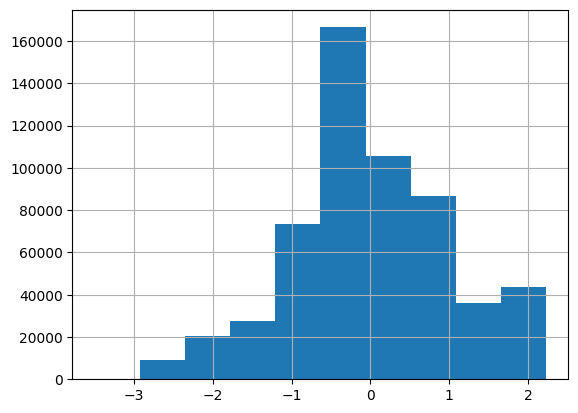

In [10]:
df['V1'].hist()

<Axes: ylabel='Density'>

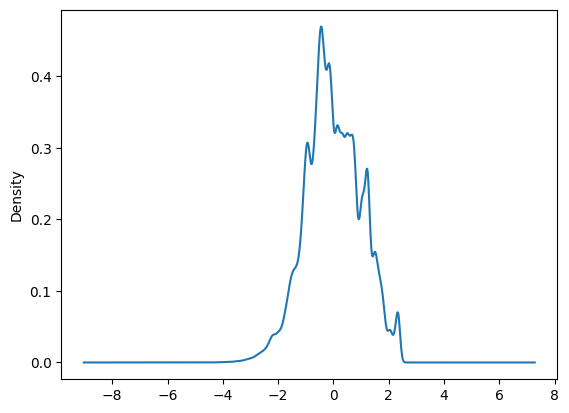

In [11]:
df['V4'].plot(kind="kde")

# Tensores com variáveis dependentes e independentes

Apenas 1000 linhas do csv serão usadas para treinar e validar o modelo. Treinar com a base de dados inteira enche toda a memória do notebook (30 GB). 

In [12]:
df['Class'][:1000].sum() # Simplismente pegar os 1000 primeiros valores não traria bons valores para treinar o modelo.

2

In [13]:
idx_lines = []
size_fraud = 0
size_non_fraud = 0
for x in df.index:
    if df.loc[x, 'Class'] == 0 and size_non_fraud < 500:
        idx_lines.append(x)
        size_non_fraud += 1
    elif df.loc[x, 'Class'] == 1 and size_fraud < 500:
        idx_lines.append(x)
        size_fraud += 1
    elif size_fraud == 500 and size_non_fraud == 500:
        break

In [14]:
df.loc[idx_lines]['Class'].sum(), df.loc[idx_lines]['Class'].count()

(500, 1000)

In [15]:
df.loc[idx_lines, "Class"]

0         0
1         0
2         0
3         0
4         0
         ..
284810    1
284811    1
284812    1
284813    1
284814    1
Name: Class, Length: 1000, dtype: int64

In [16]:
import torch
from torch import tensor

t_dep = tensor(df.loc[idx_lines, 'Class'], dtype=torch.float)

In [17]:
indep_cols = df.columns[1:-1] # A primeira coluna é o ID, a ultima é a Class.

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep = t_indep[idx_lines]
t_indep

tensor([[-2.6065e-01, -4.6965e-01,  2.4963e+00,  ..., -8.1230e-02,
         -1.5105e-01,  1.7982e+04],
        [ 9.8510e-01, -3.5605e-01,  5.5806e-01,  ..., -2.4805e-01,
         -6.4512e-02,  6.5314e+03],
        [-2.6027e-01, -9.4938e-01,  1.7285e+00,  ..., -3.0026e-01,
         -2.4472e-01,  2.5135e+03],
        ...,
        [ 8.4064e-01,  3.0462e-01, -6.9429e-01,  ...,  2.3839e-01,
          1.9078e-01,  2.2226e+04],
        [ 1.9342e-01, -1.5892e-01,  3.3835e-01,  ...,  8.7877e-02,
          1.0196e-01,  3.8949e+03],
        [-6.0042e-01,  6.4673e-01, -7.5201e-01,  ...,  8.1397e-01,
          1.0218e+00,  1.6644e+04]])

In [18]:
t_indep.shape

torch.Size([1000, 29])

# Criando o modelo linear

In [19]:
torch.manual_seed(42)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)
coeffs

tensor([0.8823, 0.9150, 0.3829, 0.9593, 0.3904, 0.6009, 0.2566, 0.7936, 0.9408,
        0.1332, 0.9346, 0.5936, 0.8694, 0.5677, 0.7411, 0.4294, 0.8854, 0.5739,
        0.2666, 0.6274, 0.2696, 0.4414, 0.2969, 0.8317, 0.1053, 0.2695, 0.3588,
        0.1994, 0.5472])

In [20]:
t_indep

tensor([[-2.6065e-01, -4.6965e-01,  2.4963e+00,  ..., -8.1230e-02,
         -1.5105e-01,  1.7982e+04],
        [ 9.8510e-01, -3.5605e-01,  5.5806e-01,  ..., -2.4805e-01,
         -6.4512e-02,  6.5314e+03],
        [-2.6027e-01, -9.4938e-01,  1.7285e+00,  ..., -3.0026e-01,
         -2.4472e-01,  2.5135e+03],
        ...,
        [ 8.4064e-01,  3.0462e-01, -6.9429e-01,  ...,  2.3839e-01,
          1.9078e-01,  2.2226e+04],
        [ 1.9342e-01, -1.5892e-01,  3.3835e-01,  ...,  8.7877e-02,
          1.0196e-01,  3.8949e+03],
        [-6.0042e-01,  6.4673e-01, -7.5201e-01,  ...,  8.1397e-01,
          1.0218e+00,  1.6644e+04]])

# Removing the dominance of Amount from other columns

In [21]:
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

In [22]:
t_indep*coeffs

tensor([[-0.1227, -0.0985,  0.2393,  ..., -0.0060, -0.0073,  0.4102],
        [ 0.4637, -0.0747,  0.0535,  ..., -0.0184, -0.0031,  0.1490],
        [-0.1225, -0.1992,  0.1657,  ..., -0.0223, -0.0118,  0.0573],
        ...,
        [ 0.3957,  0.0639, -0.0666,  ...,  0.0177,  0.0092,  0.5070],
        [ 0.0910, -0.0333,  0.0324,  ...,  0.0065,  0.0049,  0.0889],
        [-0.2826,  0.1357, -0.0721,  ...,  0.0604,  0.0491,  0.3797]])

In [23]:
t_indep = t_indep / vals

# Dummy Predictions

In [24]:
def up_low(val):
    if val > 0.5:
        return 1
    return 0

In [25]:
preds = (t_indep*coeffs).sum(axis=1)
preds

tensor([-8.1824e-03,  4.2561e-01,  9.2974e-02, -3.5421e-01,  1.1053e-01,
         8.7937e-03, -1.1607e-01, -8.5973e-02,  9.1040e-02,  1.3781e-01,
         2.0727e-01,  3.8392e-01,  2.5455e-01,  2.2033e-01,  1.5763e-01,
        -8.8181e-02,  3.8856e-01, -1.9566e-01, -2.4839e-01,  1.2945e-01,
         1.9718e-01,  1.2177e-01,  7.5798e-02,  2.5790e-01,  1.8334e-01,
        -2.1662e-01,  5.7719e-01,  3.0513e-01,  3.2419e-01,  3.2865e-01,
         2.0635e-01,  2.1147e-01, -1.1173e-01, -1.1173e-01, -1.1253e-01,
        -1.1253e-01, -1.1147e-01,  7.1626e-02,  3.1569e-01,  3.9001e-01,
         4.9616e-01,  5.4920e-02,  1.1954e-01,  1.7075e-01, -8.1356e-02,
         4.5483e-01, -2.5567e-01,  2.0866e-01,  1.4767e-01,  7.6092e-02,
         6.2557e-01,  1.6786e-01,  2.0919e-01,  2.0238e-01,  2.7324e-01,
         2.6515e-01,  1.5233e-01, -4.0798e-02,  2.1943e-01,  5.1726e-01,
         1.3652e-01,  2.2629e-01,  2.7828e-01,  1.1299e-01,  4.2235e-01,
        -4.5452e-01, -2.5277e-01,  2.1349e-01,  1.8

In [26]:
dummy_is_fraud = list(map(up_low,preds))

In [27]:
dummy_is_fraud.count(1), df.loc[idx_lines, 'Class'].sum() # Dados os valores iniciais, temos que: o modelo ta bom !?.

(51, 500)

# Gradient descent process

In [28]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.6549)

In [29]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

In [30]:
coeffs.requires_grad_()

tensor([0.8823, 0.9150, 0.3829, 0.9593, 0.3904, 0.6009, 0.2566, 0.7936, 0.9408,
        0.1332, 0.9346, 0.5936, 0.8694, 0.5677, 0.7411, 0.4294, 0.8854, 0.5739,
        0.2666, 0.6274, 0.2696, 0.4414, 0.2969, 0.8317, 0.1053, 0.2695, 0.3588,
        0.1994, 0.5472], requires_grad=True)

In [31]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5181, grad_fn=<MeanBackward0>)

In [32]:
loss.backward()

In [33]:
coeffs.grad

tensor([ 2.7740e-02, -5.6422e-03,  1.3630e-02, -2.7263e-02,  8.8999e-04,
         1.0095e-02,  8.1707e-03, -1.0026e-03,  4.2276e-03,  2.3222e-03,
        -2.6122e-02,  2.1553e-02,  3.7842e-04,  9.6602e-03,  3.6932e-03,
         7.6558e-03,  4.9265e-03,  3.5925e-03, -4.9300e-03, -3.7895e-04,
        -4.2781e-04, -1.7818e-04, -1.4956e-04,  4.2060e-03,  8.4954e-04,
        -5.1071e-04, -2.1844e-03, -1.7155e-03,  8.8786e-08])

In [34]:
# Run last steps again.
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([ 5.5481e-02, -1.1284e-02,  2.7260e-02, -5.4525e-02,  1.7800e-03,
         2.0190e-02,  1.6341e-02, -2.0051e-03,  8.4553e-03,  4.6444e-03,
        -5.2244e-02,  4.3105e-02,  7.5683e-04,  1.9320e-02,  7.3863e-03,
         1.5312e-02,  9.8531e-03,  7.1851e-03, -9.8600e-03, -7.5791e-04,
        -8.5561e-04, -3.5636e-04, -2.9911e-04,  8.4120e-03,  1.6991e-03,
        -1.0214e-03, -4.3689e-03, -3.4310e-03,  1.7757e-07])

In [35]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5171)


# Training the linear model

In [36]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=70)(df.loc[idx_lines])

In [37]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(800, 200)

In [38]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [39]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [40]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

In [41]:
def train_model(epochs=30, lr=0.01):
    #torch.manual_seed(172)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [42]:
coeffs = train_model(40, lr=0.2)

0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 0.500; 

In [43]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'V1': tensor([0.0297]),
 'V2': tensor([0.0604]),
 'V3': tensor([0.0575]),
 'V4': tensor([0.0081]),
 'V5': tensor([0.0932]),
 'V6': tensor([0.0405]),
 'V7': tensor([0.0588]),
 'V8': tensor([0.0333]),
 'V9': tensor([0.0248]),
 'V10': tensor([0.0175]),
 'V11': tensor([0.0486]),
 'V12': tensor([0.0228]),
 'V13': tensor([0.0592]),
 'V14': tensor([0.0439]),
 'V15': tensor([0.0770]),
 'V16': tensor([0.0565]),
 'V17': tensor([0.0244]),
 'V18': tensor([0.0704]),
 'V19': tensor([0.0316]),
 'V20': tensor([0.0964]),
 'V21': tensor([0.0297]),
 'V22': tensor([0.0568]),
 'V23': tensor([0.0238]),
 'V24': tensor([0.0269]),
 'V25': tensor([0.0865]),
 'V26': tensor([0.0840]),
 'V27': tensor([0.0640]),
 'V28': tensor([0.0276]),
 'Amount': tensor([0.0894])}

In [44]:
preds = calc_preds(coeffs, val_indep)

In [45]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()

In [46]:
results = val_dep.bool()==(preds>0.5)
results[:10]

tensor([[False,  True, False,  ..., False, False,  True],
        [ True, False,  True,  ...,  True,  True, False],
        [False,  True, False,  ..., False, False,  True],
        ...,
        [ True, False,  True,  ...,  True,  True, False],
        [ True, False,  True,  ...,  True,  True, False],
        [False,  True, False,  ..., False, False,  True]])

In [47]:
results.float().mean()

tensor(0.5056)

In [48]:
acc(coeffs)

tensor(0.5056)

# Neural network

In [49]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden))/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

In [50]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [51]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [52]:
coeffs = train_model(lr=1.4)


0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.501; 0.500; 0.500; 0.500; 0.500; 0.500; 

In [53]:
coeffs = train_model(lr=20)

0.501; 0.500; 0.500; 0.499; 0.499; 0.499; 0.498; 0.498; 0.498; 0.497; 0.497; 0.497; 0.496; 0.496; 0.496; 0.496; 0.495; 0.495; 0.495; 0.495; 0.495; 0.495; 0.494; 0.494; 0.494; 0.494; 0.494; 0.494; 0.494; 0.494; 

In [54]:
acc(coeffs)

tensor(0.4650)

# Deep Learning

In [55]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [89]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

In [57]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [93]:
coeffs = train_model(lr=4)

0.503; 0.500; 0.500; 0.500; 0.500; 0.499; 0.499; 0.499; 0.499; 0.499; 0.499; 0.499; 0.499; 0.499; 0.499; 0.499; 0.499; 0.499; 0.498; 0.498; 0.498; 0.498; 0.498; 0.498; 0.498; 0.498; 0.498; 0.498; 0.498; 0.498; 

In [59]:
acc(coeffs)

tensor(0.4650)

In [60]:
coeffs

([tensor([[ 2.6285e-01,  9.3346e-02,  9.7215e-04,  2.7135e-01,  1.3552e-01,
            9.4975e-02, -1.1774e-01,  2.7714e-01,  2.3174e-01,  2.2028e-01],
          [ 8.7534e-02,  1.0932e-01,  1.4441e-01, -2.3271e-02,  1.9888e-01,
            2.0304e-02, -1.0809e-01,  1.5364e-01, -7.3685e-02,  2.3902e-02],
          [ 1.1868e-01,  1.0623e-01,  1.2707e-01,  2.3309e-01, -1.4725e-02,
           -5.3174e-02, -1.1729e-01, -5.8397e-02, -1.1398e-01,  8.0028e-02],
          [-1.1451e-02, -1.0615e-01, -1.0341e-01, -1.8805e-02,  1.2798e-02,
            2.2009e-01, -9.3262e-02, -7.4557e-02,  2.0456e-01,  1.1364e-01],
          [ 6.7431e-02,  7.7699e-02,  2.2619e-01,  7.8624e-02, -2.4565e-03,
            2.0193e-01, -4.7200e-02,  1.9652e-01,  7.4355e-02, -7.7141e-02],
          [ 1.7289e-01,  1.3691e-01,  2.5312e-01, -7.3307e-02,  1.7261e-01,
           -1.0560e-01,  1.3707e-01,  1.7220e-01,  1.0944e-01,  2.5337e-01],
          [-9.0736e-02,  8.3262e-03,  1.0653e-01,  5.9794e-02,  1.2267e-01,
      

In [92]:
torch.save(coeffs,"tensor.pt")

![It aint much](https://images.deccanherald.com/deccanherald/import/sites/dh/files/articleimages/2023/05/24/meme-1221602-1684934090.jpg?w=1200&h=675&auto=format%2Ccompress&fit=max&enlarge=true)